# Chargement des id et des probas

In [1]:
import pandas as pd
df = pd.read_csv("data/training_solutions_rev1.csv", usecols=[0,1,2,3])
df

,GalaxyID,Class1.1,Class1.2,Class1.3
0,100008,0.383147,0.616853,0.000000
1,100023,0.327001,0.663777,0.009222
2,100053,0.765717,0.177352,0.056931
3,100078,0.693377,0.238564,0.068059
4,100090,0.933839,0.000000,0.066161
...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000
61574,999950,0.901216,0.098784,0.000000
61575,999958,0.202841,0.777376,0.019783
61576,999964,0.091000,0.909000,0.000000


# Suppression de la classe 3 qui n'a que 73 images...

In [2]:
df = df.drop(df[(df['Class1.3'] > df['Class1.2']) & (df['Class1.3'] > df['Class1.1'])].index)
df = df.drop(['Class1.3'], axis=1)
df.shape

(61519, 3)

# Échantillons test et d'entraînement

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=.4)
df_train.shape, df_test.shape

((36911, 3), (24608, 3))

# Chargement des images, crop, resize et normalisation

In [5]:
from skimage.transform import resize
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1, y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    val = dataframe.values
    ids = val[:,0].astype(int).astype(str)
    y = val[:,1:]
    X = []
    for i in tqdm(ids):
        x = get_image(f'data/images_training_rev1/{i}.jpg', x1, y1, shape, crop_size)
        X.append(x)
    X = np.array(X)
    return X, y

In [6]:
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 24608/24608 [02:29<00:00, 164.23it/s]


In [7]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

X_train (36911, 64, 64, 3)
y_train (36911, 2)
X_test (24608, 64, 64, 3)
y_test (24608, 2)


# Sauvegarde des array

In [8]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_test', X_test)
np.save('y_test', y_test)

# Chargement des array si existants

In [1]:
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Réduction de la dimension par ACP

In [9]:
X_train[1].shape

(64, 64, 3)

In [2]:
X_train_r = X_train.reshape(X_train.shape[0],-1)
X_test_r = X_test.reshape(X_test.shape[0],-1)
print('X_train',X_train_r.shape)
print('X_test',X_test_r.shape)

X_train (36911, 12288)
X_test (24608, 12288)


In [3]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_r[:1000])
cumsum = np.cumsum(pca.explained_variance_ratio_)
nb_dim = np.argmax(cumsum >= 0.95) + 1
print("Nombre de composants expliquant 95% de la variance :", nb_dim)

Nombre de composants expliquant 95% de la variance : 246


In [4]:
# jouer sur train/test split pour avoir moins d'images dans le train
pca = PCA(n_components=nb_dim)
X_train_pca = pca.fit_transform(X_train_r)

In [5]:
X_test_pca = pca.transform(X_test_r)

# Modèle CNN perso

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

model = Sequential()

model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 512)       14336     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 256)       1179904   
_________________________________________________________________
activation_7 (Activation)    (None, 60, 60, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 128)       295040    
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 128)      

In [13]:
# test sur moins de données (sans acp)
history = model.fit(X_train[:500], y_train[:500], epochs=10, validation_data=(X_test[:100], y_test[:100]))

Epoch 1/10
16/16 [==============================] - 74s 5s/step - loss: 0.6818 - accuracy: 0.5900 - val_loss: 0.6774 - val_accuracy: 0.5900
Epoch 2/10
16/16 [==============================] - 77s 5s/step - loss: 0.6813 - accuracy: 0.5900 - val_loss: 0.6771 - val_accuracy: 0.5900
Epoch 3/10
16/16 [==============================] - 77s 5s/step - loss: 0.6811 - accuracy: 0.5900 - val_loss: 0.6768 - val_accuracy: 0.5900
Epoch 4/10
16/16 [==============================] - 77s 5s/step - loss: 0.6822 - accuracy: 0.5900 - val_loss: 0.6782 - val_accuracy: 0.5900
Epoch 5/10
16/16 [==============================] - 77s 5s/step - loss: 0.6821 - accuracy: 0.5900 - val_loss: 0.6781 - val_accuracy: 0.5900
Epoch 6/10
16/16 [==============================] - 77s 5s/step - loss: 0.6793 - accuracy: 0.5900 - val_loss: 0.6764 - val_accuracy: 0.5900
Epoch 7/10
16/16 [==============================] - 77s 5s/step - loss: 0.6807 - accuracy: 0.5900 - val_loss: 0.6770 - val_accuracy: 0.5900
Epoch 8/10
16/16 [==

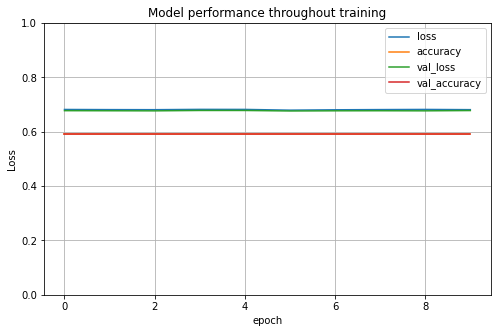

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()